# Importing required libraries

In [79]:
import os, re
import random
import datetime
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Convolution3D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input, RandomRotation, RandomZoom, RandomTranslation
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import plot_model
from typing import List, Tuple

# Pre-Configurations

In [80]:
# environment dependent paths
def get_root_and_log_path():
    pwd = os.popen('echo $PWD').read().strip()
    if pwd == '/content':
        from google.colab import drive
        drive.mount('/content/drive')
        return ('/content/drive/My Drive/Bone Marrow Cell Classification Project/archive',
                os.path.join(
                    '/content/drive/My Drive/Bone Marrow Cell Classification Project/archive',
                    'logs',
                    datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
                ))
    elif pwd == '/kaggle/working':
        return ('../input/bone-marrow-cell-classification',
                os.path.join(
                    'kaggle/temp',
                    'logs',
                    datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
                ))
    else:
        return ('/media/abetrack3/New Volume/archive',
                os.path.join(
                    '/media/abetrack3/New Volume/archive',
                    'logs',
                    datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
                ))

## Models

In [81]:
MODEL_INFO_MOBILE_NET_V2 = ('https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4', False, 224, 1, 'MobileNetV2')

MODEL_INFO_CUSTOM_CNN = ('', False, 400, 2, 'Custom CNN Model')

MODEL_INFO_RES_NET_V2 = ('https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5', False, 224, 3, 'ResnetV2')

MODEL_INFO_INCEPTION_V3 = ('https://tfhub.dev/google/imagenet/inception_v3/classification/5', False, 299, 4, 'InceptionV3')

MODEL_INFO_INCEPTION_RESNET_V2 = ('https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5', False, 299, 5, 'InceptionResnetV2')

MODEL_INFO_XCEPTION = ('', False, 299, 6, 'Xception')

MODEL_INFO_VGG16 = ('', False, 224, 7, 'Vgg16')

MODEL_INFO_VGG19 = ('', False, 224, 8, 'Vgg19')

MODEL_INFO_DENSENET121 = ('', False, 224, 9, 'Densenet121')

# Constants

In [82]:
ROOT_DATASET_PATH , LOG_DIR = get_root_and_log_path()
DATASET_PATH = f'{ROOT_DATASET_PATH}/bone_marrow_cell_dataset'


MODEL_URL, GRAY_SCALE, IMAGE_SIZE, MODEL_NO, MODEL_NAME = MODEL_INFO_RES_NET_V2
CHANNELS = 1 if GRAY_SCALE else 3
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS]
OUTPUT_SHAPE = 6
BATCH_SIZE = 32
EPOCHS = 1
TEST_SIZE = 0.2
LEARNING_RATE = 0.001
ADDITIONAL_AUGMENTATION = False
RESAMPLE_SIZE = 16_000

# Loading Resources

## Collecting paths of all image files and their respective labels in a list

In [83]:
paths_and_labels = []
def get_paths_and_labels():
    pattern = re.compile(r'.*([A-Z]{3})_[0-9]+\.jpg$')
    progress_bar = tqdm(total=171373)
    for dirname, _, filenames in os.walk('/kaggle/input/resizebm/bone_marrow_cell_dataset(resize)'):
        for filename in filenames:
            image_path = os.path.join(dirname, filename)
            image_label = pattern.findall(image_path)[0]
            paths_and_labels.append((image_path, image_label))
            progress_bar.update(1)
get_paths_and_labels()

  0%|          | 0/171373 [00:00<?, ?it/s]

## Removing Errorneous images

There are two types of errorneous images found while attempting to train the model
- The one that gives the error `Invalid Argument: jpeg::Uncompressed failed. Invalid JPEG data or crop window".`
- The one that gives the error `Corrupt JPEG data: 694 extraneous bytes before marker 0xd9`

The first one makes the code crash in runtime while the second only shows the error but continues to run anyway. All of these images are manually removed.

In [84]:
target_index = 0
for index in range(len(paths_and_labels)):
    if 'MYB_05528.jpg' in paths_and_labels[index][0]:
        target_index = index
        break
    index += 1
print(target_index)

82300


In [85]:
erroneous_index = [154407, 142934, 114530, 103387, 82990, 50923, 37625, 17332, 16616, 4429]
erroneous_index.sort(reverse=True)
for index in erroneous_index:
    paths_and_labels.pop(index)

## Original Class Counts 

In [86]:
pd.DataFrame(paths_and_labels, columns=['File_Path', 'Category']).Category.value_counts()

NGS    29421
EBO    27394
LYT    26241
ART    19629
PMO    11994
BLA    11972
NGB     9967
PLM     7629
MYB     6555
EOS     5882
MON     4040
NIF     3538
MMZ     3055
PEB     2740
BAS      441
HAC      409
OTH      294
LYI       65
FGC       47
KSC       42
ABE        8
Name: Category, dtype: int64

## Removing classes that has low instance count

In [87]:
classes_to_be_removed = ['MYB', 'EOS', 'MON', 'NIF', 'MMZ', 'PEB', 'BAS', 'HAC', 'OTH', 'LYI', 'FGC', 'KSC', 'ABE', 'NGB', 'PLM']
paths_and_labels = [(path, label) for path, label in tqdm(paths_and_labels) if label not in classes_to_be_removed]

  0%|          | 0/171363 [00:00<?, ?it/s]

## Resampling Data

In [88]:
### Undersampling Data (Select First N Samples)
def undersample_data(image_paths_and_labels: List[Tuple[str, str]]):
    length = len(image_paths_and_labels)
    return image_paths_and_labels[:min(RESAMPLE_SIZE, length)]

### Oversampling Data (Blind Copy upto total N Samples)
def oversample_data(image_paths_and_labels: List[Tuple[str, str]]):
    image_paths_and_labels = image_paths_and_labels[:] #duplicating list through list slicing
    index = 0
    while(len(image_paths_and_labels) < RESAMPLE_SIZE):
        image_paths_and_labels.append(image_paths_and_labels[index])
        index += 1
    return image_paths_and_labels

### Resample
def resample_data():
    categories = list(set([label for path, label in paths_and_labels]))
    label_separated_paths_and_labels = {}
    for each_category in categories:
        label_separated_paths_and_labels[each_category] = []
    for path, label in tqdm(paths_and_labels):
        label_separated_paths_and_labels[label].append((path, label))
    new_list = []
    for each_category in  categories:
        if len(label_separated_paths_and_labels[each_category]) < RESAMPLE_SIZE:
            new_list += oversample_data(label_separated_paths_and_labels[each_category])
        else:
            new_list += undersample_data(label_separated_paths_and_labels[each_category])
    return new_list

paths_and_labels = resample_data()

  0%|          | 0/126651 [00:00<?, ?it/s]

## Creating pandas DataFrame

In [89]:
df = pd.DataFrame(paths_and_labels, columns=['File_Path', 'Category'])
df

,File_Path,Category
0,/kaggle/input/resizebm/bone_marrow_cell_datase...,LYT
1,/kaggle/input/resizebm/bone_marrow_cell_datase...,LYT
2,/kaggle/input/resizebm/bone_marrow_cell_datase...,LYT
3,/kaggle/input/resizebm/bone_marrow_cell_datase...,LYT
4,/kaggle/input/resizebm/bone_marrow_cell_datase...,LYT
...,...,...
95995,/kaggle/input/resizebm/bone_marrow_cell_datase...,BLA
95996,/kaggle/input/resizebm/bone_marrow_cell_datase...,BLA
95997,/kaggle/input/resizebm/bone_marrow_cell_datase...,BLA
95998,/kaggle/input/resizebm/bone_marrow_cell_datase...,BLA


In [90]:
df.Category.value_counts()

LYT    16000
ART    16000
PMO    16000
EBO    16000
NGS    16000
BLA    16000
Name: Category, dtype: int64

# Splitting Dataset

In [91]:
df_train, df_test = train_test_split(
    df,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=df.Category
)

df_val, df_test = train_test_split(
    df_test,
#     test_size=1.0/3.0,
    test_size=0.5,
    random_state=42,
    stratify=df_test.Category
)

# One-hot encoding

In [92]:
# One-hot encoding
def get_one_hot_encoding(data_frame, join = False):
    one_hot_encoded_ = pd.get_dummies(data_frame.Category)
    if join:
        return data_frame.join(one_hot_encoded_)
    else:
        return one_hot_encoded_

category_list = list(get_one_hot_encoding(df))
print(category_list)
get_one_hot_encoding(df)

['ART', 'BLA', 'EBO', 'LYT', 'NGS', 'PMO']


,ART,BLA,EBO,LYT,NGS,PMO
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
95995,0,1,0,0,0,0
95996,0,1,0,0,0,0
95997,0,1,0,0,0,0
95998,0,1,0,0,0,0


# Data Batches

Turns out, it requires too much memory just from loading the entire dataset into memory. By creating data batches instead of laoding the entire dataset, we can avoid this problem

## Processing images

In [93]:
def process_image(image_path : str, img_size : int = IMAGE_SIZE):
    """
    Takes an image file path and turns the image into tensor
    """
#     with tf.device('/GPU:0'):
    # Reads an image file
    image = tf.io.read_file(image_path)
    # turn jpg into numerical tensor with 3 color chanel
    image = tf.image.decode_jpeg(image, channels=3)
    # convert the color channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    #resize image to our desired value
    image = tf.image.resize(image, size=[img_size, img_size])
    #convert to gray scale
    if GRAY_SCALE:
        image = tf.image.rgb_to_grayscale(image)

    return image

# df.File_Path.map(process_image) # this is a memory killer code.... leave it commented
# df

## Image Augmentation

In [94]:
if ADDITIONAL_AUGMENTATION:
    with tf.device('/GPU:0'):
        augmentation_layers = Sequential()
        augmentation_layers.add(RandomRotation(factor=(-0.2, 0.2), fill_mode='nearest'))
        augmentation_layers.add(RandomZoom(height_factor=(0.0, 0.2), width_factor=(0.0, 0.2), fill_mode='nearest'))
        augmentation_layers.add(RandomTranslation(height_factor=(0.0, 0.2), width_factor=(0.0, 0.2), fill_mode='nearest'))

def augment_image(image):
    """
    Takes a tensor image and randomly augment it
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.2, 1.0)
    if ADDITIONAL_AUGMENTATION:
        with tf.device('/GPU:0'):
            image = augmentation_layers(image)
    return image

## functions for creating Data batches

In [95]:
def get_image_label(image_path : str, label : str) -> tuple:
    """
    Takes an image file path name and the associated label,
    processes the image and return a tuple of (image, label).
    """
    image = process_image(image_path, IMAGE_SIZE)
    return image, label

def get_augmented_image_label(image_path : str, label : str) -> tuple:
    image = process_image(image_path, IMAGE_SIZE)
    image = augment_image(image)
    return image, label

def create_data_batches(x, y=None, batch_size= BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # tuple containing only filepaths -- no labels
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices(
            (
                tf.constant(x),  # filepaths
                tf.constant(y)  # labels
            )
        )
        data_batch = data.map(get_image_label, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data_batch

    else:
        print('Creating training data batches')
        # turn filepaths into tensors
        data = tf.data.Dataset.from_tensor_slices(
            (
                tf.constant(x),  # filepaths
                tf.constant(y)  # labels
            )
        )
        # Shuffling path_names and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # create (image, label) tuples. (This also turns the image path into a preprocessed image)
        data = data.map(get_augmented_image_label, num_parallel_calls=tf.data.AUTOTUNE)

        # turn the training data into batches
        data_batch = data.batch(batch_size)
        
        # configuring data_batch to preload data to save training time
        data_batch = data_batch.prefetch(tf.data.AUTOTUNE)
        
        return data_batch

## Creating training data batches

In [96]:
# df_train = df
training_data_batches = create_data_batches(
    df_train.File_Path,
    get_one_hot_encoding(df_train)
)
training_data_batches.element_spec

Creating training data batches


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 6), dtype=tf.uint8, name=None))

## Creating validation data batches

In [97]:
validation_data_batches = create_data_batches(
    df_val.File_Path,
    get_one_hot_encoding(df_val),
    valid_data=True
)

Creating validation data batches...


# Modeling

## Creating and Building Model

### Tensorflow Hub Models

In [98]:
def create_tfhub_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print('Building Model with: ' + model_url)

    # setup model layers
    model_ = tf.keras.Sequential(
        [
            # Layer 1 input layer
            hub.KerasLayer(
                model_url,
                name=MODEL_NAME,
                trainable=True,
                arguments=dict(batch_norm_momentum=0.997)
            ),

            # Layer 2 output Layer
            tf.keras.layers.Dense(
                units = output_shape,
                activation = 'softmax'
            )
        ]
    )

    # Compile the model
    model_.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        metrics = ['accuracy']
    )

    # Build the model
    model_.build(input_shape)

    return model_

### Custom CNN Model

In [99]:
def create_custom_cnn_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE):
    model_ = Sequential()

    model_.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))

    model_.add(Convolution2D(
        filters=32,
        kernel_size=(3, 3),
        activation = 'relu',
        data_format='channels_last'
    ))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

#     model_.add(Convolution2D(128, (3, 3), activation = 'relu'))
#     model_.add(BatchNormalization(axis = -1))
#     model_.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Convolution2D(1024, (3, 3), activation = 'relu'))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Convolution2D(2048, (3, 3), activation = 'relu'))
    model_.add(BatchNormalization(axis = -1))
    model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

#     model_.add(Convolution2D(2048, (3, 3), activation = 'relu'))
#     model_.add(BatchNormalization(axis = -1))
#     model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

#     model_.add(Convolution2D(32, (3, 3), activation = 'relu'))
#     model_.add(BatchNormalization(axis = -1))
#     model_.add(AveragePooling2D(pool_size = (2, 2), data_format="channels_last"))
#     model_.add(Dropout(0.2))

    model_.add(Flatten())
#     model_.add(Dense(activation = 'relu', units=2048))
#     model_.add(Dense(activation = 'relu', units=1024))
#     model_.add(Dense(activation = 'relu', units=512))
    model_.add(Dense(activation = 'relu', units=256))
    model_.add(Dense(activation = 'relu', units=128))
    model_.add(Dense(activation = 'relu', units=64))
    model_.add(Dense(activation = 'relu', units=32))
    model_.add(Dense(activation = 'relu', units=16))
    model_.add(BatchNormalization(axis = -1))

    model_.add(Dense(activation = 'relu', units=64))
    model_.add(BatchNormalization(axis = -1))
#     model_.add(Dropout(0.1))

    model_.add(Dense(activation = 'softmax', units=OUTPUT_SHAPE))

    model_.compile(
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy']
    )

    model_.build(INPUT_SHAPE)

    return model_

### keras applications api models

In [100]:
def create_keras_application_api_model(model_no = MODEL_NO, input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE):
    base_model_class = None
    if model_no == 6: #Xception
        base_model_class, input_preprocessor = tf.keras.applications.Xception, tf.keras.applications.xception.preprocess_input
    elif model_no == 7: #Vgg16
        base_model_class, input_preprocessor = tf.keras.applications.VGG16, tf.keras.applications.vgg16.preprocess_input
    elif model_no == 8: #Vgg19
        base_model_class, input_preprocessor = tf.keras.applications.VGG19, tf.keras.applications.vgg19.preprocess_input
    elif model_no == 9: #Densenet121
        base_model_class, input_preprocessor = tf.keras.applications.DenseNet121, tf.keras.applications.densenet.preprocess_input
    
    
    base_model = base_model_class(
        include_top=False,
        weights="imagenet",
#         input_tensor=None,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
        pooling='max',
#         classes=1000,
#         classifier_activation="softmax"
    )
    base_model.trainable = True
    
    
    input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    out = input_preprocessor(input_layer)
    out = base_model(out)
    out = Dense(units = output_shape, activation='relu')(out)
    
    model_ = tf.keras.Model(inputs = [input_layer], outputs = [out])
    
    # Compile the model
    model_.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE),
        metrics = ['accuracy']
    )
    
    model_.build(input_shape)
    
    return model_
    

### Model Factory

In [101]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    if MODEL_NO in [1, 3, 4, 5]:
        return create_tfhub_model(input_shape, output_shape, model_url)
    elif MODEL_NO == 2:
        return create_custom_cnn_model(input_shape, output_shape)
    elif MODEL_NO in [6, 7, 8, 9]:
        return create_keras_application_api_model(MODEL_NO, input_shape, output_shape)

### Plotting Model

Building Model with: https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5


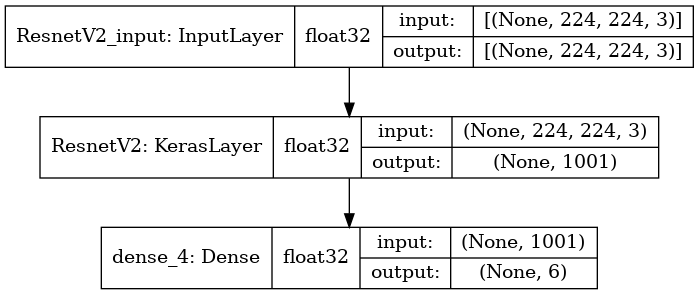

In [102]:
plot_model(create_model(), show_shapes=True, show_dtype=True, expand_nested=True)

## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving

Tensorboard for tracking model progress
Early stopping to stop training early if a model stops improving

In [103]:
# %load_ext tensorboard

In [104]:
def get_tensorboard_instance():
    return tf.keras.callbacks.TensorBoard(LOG_DIR)
def get_early_stopping_instance():
    return tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                            patience = 3)
def get_reduce_lr_on_plateau_instance():
    return tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                patience=3,
                                                verbose=1,
                                                min_lr=0.0000001)

## Training and fitting data into model

In [ ]:
def train_model(train_data, val_data):
    """
    Trains a given model and return the trained version
    """
    # create a model
    model_ = create_model()
    
    print(model_.summary())

    # create a new TensorBoard session every time we train a model
    # tensorboard = get_tensorboard_instance()

    # create a early stopping instance
    # early_stopping = get_early_stopping_instance()
    
    # create a reduce_learning_rate_on_plateaue callback
    reduce_lr_on_plateau_instance = get_reduce_lr_on_plateau_instance()

    # Fit the model to the data passing it the callbacks we created
    training_history_ = model_.fit(
        x = train_data,
        epochs = EPOCHS,
        validation_data = val_data,
        callbacks = [reduce_lr_on_plateau_instance]
    )

    # Return the fitted model
    return model_, training_history_
model, training_history = train_model(training_data_batches, validation_data_batches)

Building Model with: https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ResnetV2 (KerasLayer)        (None, 1001)              60382697  
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 6012      
Total params: 60,388,709
Trainable params: 60,244,965
Non-trainable params: 143,744
_________________________________________________________________
None


In [ ]:
tf.config.list_physical_devices("GPU")

# Evaluation

## Accuracy and Loss Curve

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(training_history.epoch, training_history.history['loss'], label='Loss')
plt.plot(training_history.epoch, training_history.history['val_loss'], label='Validation Loss')
plt.plot(training_history.epoch, training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.epoch, training_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Accuracy & Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy & Loss Value')
plt.xticks(training_history.epoch)
plt.grid()

### Loss Curve

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(training_history.epoch, training_history.history['loss'], label='Loss')
plt.plot(training_history.epoch, training_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.xticks(training_history.epoch)
plt.grid()

### Accuracy Curve

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(training_history.epoch, training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.epoch, training_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Percentage')

## Predicting on Test Dataset

### Creating Test Data Batch

In [ ]:
test_data_batches = create_data_batches(
    df_test.File_Path,
    get_one_hot_encoding(df_test),
    valid_data=True
)

### Predicting on Test Dataset

In [ ]:
predictions = model.predict(test_data_batches, verbose=1)
predictions

### Testing the model on Test Dataset

In [ ]:
model.evaluate(test_data_batches)

## Classification Score

### Functions to get labels

In [ ]:
def get_prediction_labels(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """
    return category_list[np.argmax(prediction_probabilities)]

def unbatchify_and_get_labels(data):
    """
    Takes a batched dataset of (image, label) Tensors and return separates arrays of images and labels
    """
#     images_ = []
    labels_ = []
    # Loop through unbatched data
    for image, label in tqdm(data.unbatch().as_numpy_iterator()):
#         images_.append(image)
        labels_.append(get_prediction_labels(label))
    return labels_
#     return images_, labels_
# images, labels = unbatchify(validation_data_batches)

### Getting the labels

In [ ]:
predicted_labels = [get_prediction_labels(prediction) for prediction in tqdm(predictions)]
actual_labels = unbatchify_and_get_labels(test_data_batches)

### Calculating Classification Score

In [ ]:
print(classification_report(actual_labels, predicted_labels))

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

label_map = {
    'ART' : 0,
    'BLA' : 1,
    'EBO' : 2,
    'LYT' : 3,
#     'NGB' : 4,
    'NGS' : 4,
#     'PLM' : 6,
    'PMO' : 5
}

cm = tf.math.confusion_matrix(
    labels = [label_map[label] for label in actual_labels], #converting labels to numeric values since string labels cannot be cast to int
    predictions = [label_map[label] for label in predicted_labels] #converting labels to numeric values since string labels cannot be cast to int
)
plt.figure(figsize = (12, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## ROC-AUC Curve

In [ ]:
actual_labels_binarized = label_binarize(actual_labels, classes=category_list)
fpr = {} # False Positive Rate
tpr = {} # True Positive Rate
thresh ={} # Threshold
roc_auc = dict()

plt.figure(figsize = (10, 7))
for i in range(len(category_list)):
    fpr[i], tpr[i], thresh[i] = roc_curve(actual_labels_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(category_list[i],roc_auc[i]))


plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()